# Phase35 UC-13 DR-DiD Tune/Estimate

## Setup

In [1]:
from __future__ import annotations

import json
from datetime import datetime, timezone
from pathlib import Path

import numpy as np
import pandas as pd
from IPython.display import Image, display

from veldra.api import estimate_dr, evaluate, fit, tune
from veldra.api.artifact import Artifact
from veldra.diagnostics import (
    binary_metrics,
    build_binary_table,
    build_dr_table,
    build_drdid_table,
    build_frontier_table,
    build_multiclass_table,
    build_regression_table,
    compute_balance_smd,
    compute_importance,
    compute_overlap_stats,
    compute_shap,
    compute_shap_multiclass,
    frontier_metrics,
    multiclass_metrics,
    plot_confusion_matrix,
    plot_error_histogram,
    plot_feature_importance,
    plot_frontier_scatter,
    plot_if_distribution,
    plot_learning_curve,
    plot_love_plot,
    plot_parallel_trends,
    plot_pinball_histogram,
    plot_propensity_distribution,
    plot_roc_comparison,
    plot_roc_multiclass,
    plot_shap_summary,
    plot_timeseries_prediction,
    plot_timeseries_residual,
    plot_weight_distribution,
    regression_metrics,
)

ROOT = Path('.').resolve()
OUT_DIR = ROOT / 'examples' / 'out' / 'phase35_uc13_drdid_tune_estimate'
OUT_DIR.mkdir(parents=True, exist_ok=True)
diag_dir = OUT_DIR / 'diagnostics'
diag_dir.mkdir(parents=True, exist_ok=True)
UC_ID = 'UC-13'


/home/rem/repos/VeldraML/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data Preparation

In [2]:
source_df = pd.read_csv(ROOT / 'data' / 'cps_panel.csv')
source_path = OUT_DIR / 'cps_panel.csv'
source_df.to_csv(source_path, index=False)
target_col = 'target'
treatment_col = 'treatment'


## 2. Feature Selection

In [3]:
covariate_cols = [col for col in ['age', 'skill'] if col in source_df.columns]
if not covariate_cols:
    raise ValueError('No covariate columns found for DR-DiD tuning/estimation.')


## 3. Base Config

In [4]:
base_config = {
    'config_version': 1,
    'task': {'type': 'regression'},
    'data': {
        'path': str(source_path),
        'target': target_col,
    },
    'split': {'type': 'group', 'n_splits': 3, 'group_col': 'unit_id', 'seed': 42},
    'train': {
        'seed': 42,
        'num_boost_round': 1200,
        'early_stopping_rounds': 120,
        'early_stopping_validation_fraction': 0.2,
        'auto_num_leaves': True,
        'num_leaves_ratio': 1.0,
        'min_data_in_leaf_ratio': 0.01,
        'min_data_in_bin_ratio': 0.01,
        'metrics': ['rmse', 'mae'],
        'lgb_params': {
            'learning_rate': 0.02,
            'max_depth': 10,
            'feature_fraction': 1.0,
            'bagging_fraction': 1.0,
            'bagging_freq': 0,
            'lambda_l1': 0.0,
            'lambda_l2': 0.000001,
            'first_metric_only': True,
        },
    },
    'causal': {
        'method': 'dr_did',
        'treatment_col': treatment_col,
        'estimand': 'att',
        'design': 'panel',
        'time_col': 'time',
        'post_col': 'post',
        'unit_id_col': 'unit_id',
    },
    'export': {'artifact_dir': str(OUT_DIR / 'artifacts')},
}


## 4. Tuning Config

In [5]:
tune_config = json.loads(json.dumps(base_config))
tune_config['tuning'] = {
    'enabled': True,
    'n_trials': 3,
    'resume': True,
    'preset': 'standard',
    'objective': 'drdid_balance_priority',
}


## 5. Run tune()

In [6]:
tune_result = tune(tune_config)
trials_df = pd.read_parquet(tune_result.metadata['trials_path'])
tuning_trials_path = OUT_DIR / 'tuning_trials.csv'
trials_df.to_csv(tuning_trials_path, index=False)
best_params_path = OUT_DIR / 'best_params.json'
best_params_path.write_text(json.dumps(tune_result.best_params, indent=2), encoding='utf-8')
display(trials_df.head(10))


[I 2026-02-23 00:11:16,161] Using an existing study with name 'regression_tune_1cc491632cf2' instead of creating a new one.


[I 2026-02-23 00:11:16,405] Trial 15 finished with value: 1000000.3415503799 and parameters: {'learning_rate': 0.016129423372474243, 'train.num_leaves_ratio': 0.5944950717610656, 'train.early_stopping_validation_fraction': 0.18354506160426748, 'max_bin': 217, 'train.min_data_in_leaf_ratio': 0.011202237858275182, 'train.min_data_in_bin_ratio': 0.037050834074441145, 'max_depth': 5, 'feature_fraction': 0.7237211563571774, 'lambda_l2': 0.03348018282714739}. Best is trial 0 with value: 1000000.3415503799.


[I 2026-02-23 00:11:16,605] Trial 16 finished with value: 1000000.3415503799 and parameters: {'learning_rate': 0.0356217376515369, 'train.num_leaves_ratio': 0.9153368210114128, 'train.early_stopping_validation_fraction': 0.27104881922364477, 'max_bin': 186, 'train.min_data_in_leaf_ratio': 0.07617011474196908, 'train.min_data_in_bin_ratio': 0.07208475606887951, 'max_depth': 10, 'feature_fraction': 0.8342540130049294, 'lambda_l2': 0.005600036372146629}. Best is trial 0 with value: 1000000.3415503799.


[I 2026-02-23 00:11:16,804] Trial 17 finished with value: 1000000.3415503799 and parameters: {'learning_rate': 0.06644526695314788, 'train.num_leaves_ratio': 0.7527557721217475, 'train.early_stopping_validation_fraction': 0.2623776429355853, 'max_bin': 165, 'train.min_data_in_leaf_ratio': 0.09700007023622104, 'train.min_data_in_bin_ratio': 0.054643718095274296, 'max_depth': 4, 'feature_fraction': 0.5920574620925351, 'lambda_l2': 0.07719318644643555}. Best is trial 0 with value: 1000000.3415503799.


,number,value,state,param_learning_rate,param_train.num_leaves_ratio,param_train.early_stopping_validation_fraction,param_max_bin,param_train.min_data_in_leaf_ratio,param_train.min_data_in_bin_ratio,param_max_depth,...,balance_violation,estimate,objective_stage,objective_value,overlap_metric,penalty,penalty_weight,smd_max_unweighted,smd_max_weighted,std_error
0,0,1.000000e+06,COMPLETE,0.023689,0.975357,0.246399,204,0.024042,0.024040,3,...,0.34155,1778.867167,violated,1.000000e+06,1.0,0.34155,1.0,0.665617,0.44155,306.422345
1,1,1.000000e+06,COMPLETE,0.051059,0.510292,0.293982,234,0.029111,0.026364,5,...,0.34155,1778.867167,violated,1.000000e+06,1.0,0.34155,1.0,0.665617,0.44155,306.422345
2,2,1.000000e+06,COMPLETE,0.027036,0.645615,0.222371,144,0.036293,0.042973,8,...,0.34155,1778.867167,violated,1.000000e+06,1.0,0.34155,1.0,0.665617,0.44155,306.422345
3,3,1.000000e+06,COMPLETE,0.023689,0.975357,0.246399,204,0.024042,0.024040,3,...,0.34155,1778.867167,violated,1.000000e+06,1.0,0.34155,1.0,0.665617,0.44155,306.422345
4,4,1.000000e+06,COMPLETE,0.051059,0.510292,0.293982,234,0.029111,0.026364,5,...,0.34155,1778.867167,violated,1.000000e+06,1.0,0.34155,1.0,0.665617,0.44155,306.422345
5,5,1.000000e+06,COMPLETE,0.027036,0.645615,0.222371,144,0.036293,0.042973,8,...,0.34155,1778.867167,violated,1.000000e+06,1.0,0.34155,1.0,0.665617,0.44155,306.422345
6,6,1.000000e+06,COMPLETE,0.023689,0.975357,0.246399,204,0.024042,0.024040,3,...,0.34155,1778.867167,violated,1.000000e+06,1.0,0.34155,1.0,0.665617,0.44155,306.422345
7,7,1.000000e+06,COMPLETE,0.051059,0.510292,0.293982,234,0.029111,0.026364,5,...,0.34155,1778.867167,violated,1.000000e+06,1.0,0.34155,1.0,0.665617,0.44155,306.422345
8,8,1.000000e+06,COMPLETE,0.027036,0.645615,0.222371,144,0.036293,0.042973,8,...,0.34155,1778.867167,violated,1.000000e+06,1.0,0.34155,1.0,0.665617,0.44155,306.422345
9,9,1.000000e+06,COMPLETE,0.023689,0.975357,0.246399,204,0.024042,0.024040,3,...,0.34155,1778.867167,violated,1.000000e+06,1.0,0.34155,1.0,0.665617,0.44155,306.422345


## 6. Apply best_params

In [7]:
estimate_config = json.loads(json.dumps(base_config))
for key, value in tune_result.best_params.items():
    if key.startswith('train.'):
        estimate_config['train'][key.split('.', 1)[1]] = value
    else:
        estimate_config['train'].setdefault('lgb_params', {})[key] = value


## 7. Run Estimation

In [8]:
result = estimate_dr(estimate_config)
obs_df = pd.read_parquet(result.metadata['observation_path'])


## 8. Metrics Summary

In [9]:
metrics_df = pd.DataFrame(
    [
        {
            'label': 'drdid_att',
            'estimate': result.estimate,
            'std_error': result.std_error,
            'ci_lower': result.ci_lower,
            'ci_upper': result.ci_upper,
            'overlap_metric': result.metrics.get('overlap_metric'),
            'smd_max_unweighted': result.metrics.get('smd_max_unweighted'),
            'smd_max_weighted': result.metrics.get('smd_max_weighted'),
        }
    ]
)
metrics_path = OUT_DIR / 'metrics.csv'
metrics_df.to_csv(metrics_path, index=False)
display(metrics_df)


,label,estimate,std_error,ci_lower,ci_upper,overlap_metric,smd_max_unweighted,smd_max_weighted
0,drdid_att,1778.867167,306.422345,1178.27937,2379.454963,1.0,0.665617,0.44155


## 9. DR-DiD Table

In [10]:
drdid_table = build_drdid_table(obs_df)
drdid_table_path = OUT_DIR / 'drdid_table.csv'
drdid_table.to_csv(drdid_table_path, index=False)
display(drdid_table.head(10))


,treatment,outcome,e_raw,e_hat,m1_hat,m0_hat,psi,weight,unit_id,y_pre,y_post,y_diff
0,0,1185.966135,0.367310,0.316871,2719.721526,698.339818,-714.273270,-1.464796,0,8558.025984,9743.992119,1185.966135
1,0,2079.893191,0.661924,0.405789,2628.095609,1057.609291,-2204.596437,-2.156540,1,16486.460037,18566.353228,2079.893191
2,0,1527.588246,0.664690,0.406665,2818.958677,1040.098214,-1055.116834,-2.164386,2,16897.640944,18425.229190,1527.588246
3,0,528.382299,0.165836,0.262561,2719.721526,807.675364,314.024031,-1.124353,3,12101.232884,12629.615183,528.382299
4,0,1373.094339,0.565624,0.375703,2628.095609,881.234835,-934.741115,-1.900423,4,8485.026692,9858.121032,1373.094339
5,0,-128.098461,0.188088,0.268257,2818.958677,830.422763,1109.665289,-1.157685,5,15428.385764,15300.287303,-128.098461
6,0,1557.075414,0.079082,0.241112,2719.721526,1054.881939,-503.859718,-1.003318,6,12209.702716,13766.778130,1557.075414
7,0,1445.397771,0.173755,0.264579,2628.095609,1057.609291,-440.567940,-1.136104,7,9909.897575,11355.295346,1445.397771
8,0,993.661992,0.343749,0.310214,2818.958677,1040.098214,65.947864,-1.420182,8,10518.545412,11512.207404,993.661992
9,0,556.998722,0.367310,0.316871,2719.721526,698.339818,207.035928,-1.464796,9,9408.968851,9965.967573,556.998722


## 10. Balance Table

In [11]:
base_cov = (
    source_df.loc[source_df['post'] == 0, ['unit_id', *covariate_cols, treatment_col]]
    .sort_values('unit_id')
    .reset_index(drop=True)
)
smd_unweighted = compute_balance_smd(base_cov[covariate_cols], base_cov[treatment_col])
smd_weighted = compute_balance_smd(base_cov[covariate_cols], base_cov[treatment_col], obs_df['weight'])
balance_df = smd_unweighted.merge(
    smd_weighted,
    on='feature',
    suffixes=('_unweighted', '_weighted'),
    how='outer',
)
balance_path = OUT_DIR / 'balance_smd.csv'
balance_df.to_csv(balance_path, index=False)
display(balance_df)


,feature,smd_unweighted,smd_weighted
0,age,0.343887,0.281062
1,skill,0.665617,0.441550


## 11. Influence Function Distribution

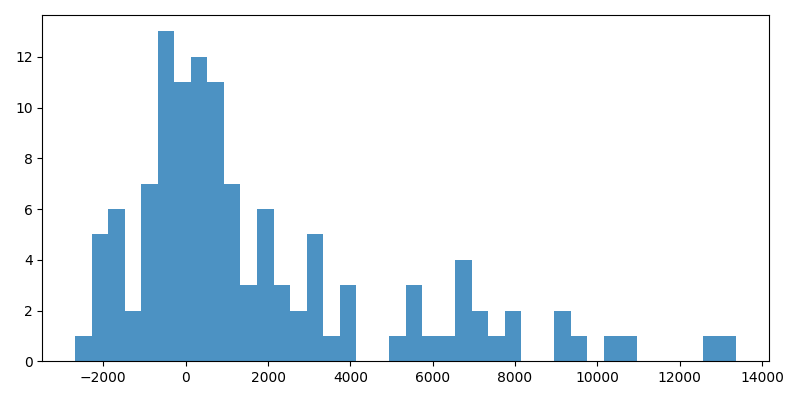

In [12]:
if_path = diag_dir / 'if_distribution.png'
plot_if_distribution(obs_df['psi'].to_numpy(dtype=float), if_path)
display(Image(filename=str(if_path)))


## 12. Parallel Trends

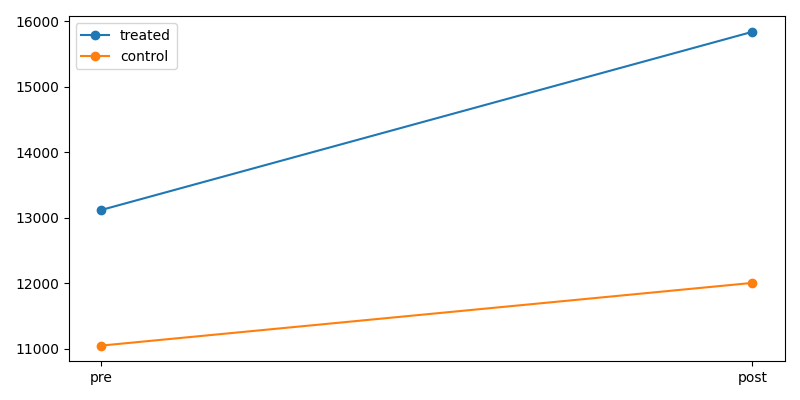

In [13]:
means = (
    source_df.groupby(['post', treatment_col])[target_col]
    .mean()
    .unstack(treatment_col)
    .reindex(index=[0, 1], columns=[0, 1])
)
parallel_path = diag_dir / 'parallel_trends.png'
plot_parallel_trends(
    means[1].to_numpy(dtype=float),
    means[0].to_numpy(dtype=float),
    ['pre', 'post'],
    parallel_path,
)
display(Image(filename=str(parallel_path)))


## 13. Propensity / Weight Distribution

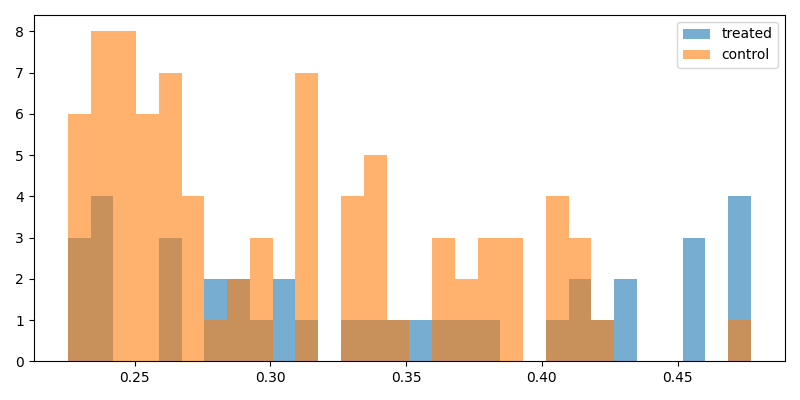

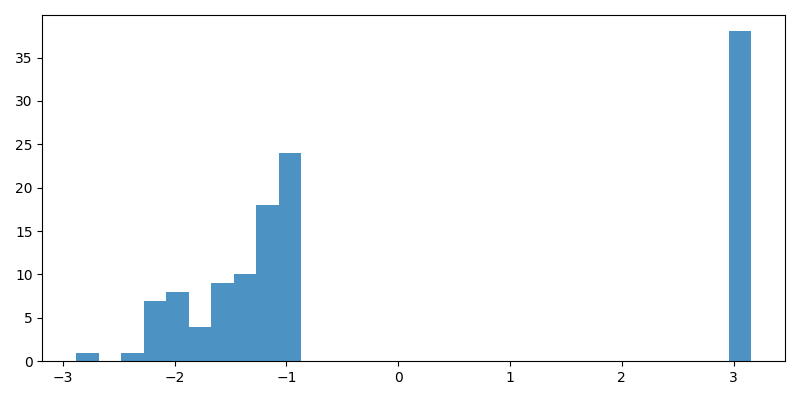

In [14]:
prop_path = diag_dir / 'propensity_distribution.png'
plot_propensity_distribution(
    obs_df['e_hat'].to_numpy(dtype=float),
    obs_df['treatment'].to_numpy(dtype=int),
    prop_path,
)
weight_path = diag_dir / 'weight_distribution.png'
plot_weight_distribution(obs_df['weight'].to_numpy(dtype=float), weight_path)
display(Image(filename=str(prop_path)))
display(Image(filename=str(weight_path)))


## 14. Love Plot

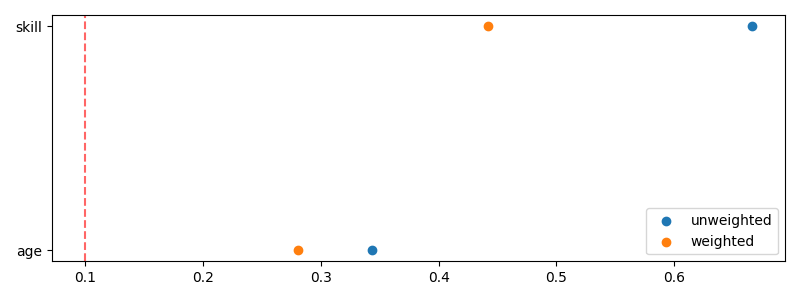

In [15]:
love_path = diag_dir / 'love_plot.png'
plot_love_plot(smd_unweighted, smd_weighted, love_path)
display(Image(filename=str(love_path)))


## 15. Prepare Summary

In [16]:
summary_outputs = [
    source_path,
    metrics_path,
    drdid_table_path,
    balance_path,
    tuning_trials_path,
    best_params_path,
    if_path,
    parallel_path,
    prop_path,
    weight_path,
    love_path,
]
artifact_path_for_summary = Path(result.metadata.get('summary_path', OUT_DIR)).parent


## Result Summary

In [17]:
SUMMARY = {
    "uc": UC_ID,
    "executed_at_utc": datetime.now(timezone.utc).isoformat(),
    "status": "passed",
    "artifact_path": str(artifact_path_for_summary),
    "outputs": [str(p) for p in summary_outputs],
    "metrics": metrics_df.round(6).to_dict(orient="records"),
}
(OUT_DIR / "summary.json").write_text(json.dumps(SUMMARY, indent=2), encoding="utf-8")
SUMMARY


{'uc': 'UC-13',
 'executed_at_utc': '2026-02-22T15:11:17.245900+00:00',
 'status': 'passed',
 'artifact_path': '/home/rem/repos/VeldraML/examples/out/phase35_uc13_drdid_tune_estimate/artifacts/causal/7b893fc5f0be4cdc83b405235c84af9e',
 'outputs': ['/home/rem/repos/VeldraML/examples/out/phase35_uc13_drdid_tune_estimate/cps_panel.csv',
  '/home/rem/repos/VeldraML/examples/out/phase35_uc13_drdid_tune_estimate/metrics.csv',
  '/home/rem/repos/VeldraML/examples/out/phase35_uc13_drdid_tune_estimate/drdid_table.csv',
  '/home/rem/repos/VeldraML/examples/out/phase35_uc13_drdid_tune_estimate/balance_smd.csv',
  '/home/rem/repos/VeldraML/examples/out/phase35_uc13_drdid_tune_estimate/tuning_trials.csv',
  '/home/rem/repos/VeldraML/examples/out/phase35_uc13_drdid_tune_estimate/best_params.json',
  '/home/rem/repos/VeldraML/examples/out/phase35_uc13_drdid_tune_estimate/diagnostics/if_distribution.png',
  '/home/rem/repos/VeldraML/examples/out/phase35_uc13_drdid_tune_estimate/diagnostics/parallel_tr